#import

In [61]:
!python -c 'import keras; print("Keras version "+ keras.__version__)'

Keras version 2.4.3


In [1]:
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as pdr #data 받아오는 api 라이브러리
from pandas import json_normalize
import numpy as np
import plotly as py
import plotly.graph_objs as go
import requests
from datetime import datetime
import traceback
import os
import time
from datetime import timedelta

import tensorflow as tf
from keras import metrics
from keras.layers import *
from keras.models import *
from keras.callbacks import *
from sklearn.preprocessing import MinMaxScaler

plt.style.use('bmh')
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.2.0


In [1]:
!pwd

/home/oslab/csj/notebooks/Code/stock


In [2]:
#사용할 GPU 설정 재설정하려면 프로세스 재시작해야함
os.environ['CUDA_VISIBLE_DEVICES']='0'#tf.debugging.set_log_device_placement(True) #어떤 장치가 할당되었는지 확인 용도인데 에러뜸

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU만 사용하도록 제한
  try:
    tf.config.experimental.set_visible_devices(gpus[:], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    # 프로그램 시작시에 접근 가능한 장치가 설정되어야만 합니다
    print(e)
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Request URL API

In [ ]:
# #BTC
# start_date = datetime(2014,7,18)
# start = int(start_date.timestamp()) #꼭 tuple이었던 변수를 datetime으로 넣을 때는 *을 붙여줘야함
# period = 86400
# #300, 900, 1800, 7200, 14400, and 86400.
# #5분, 15분, 30분, 2시간, 4시간, 1일
# ret = requests.get('https://poloniex.com/public?command=returnChartData&currencyPair=USDT_BTC&start={}&end=9999999999&period={}'.format(start, period))

In [3]:
#ETF 종목
#etf_url = requests.get('https://finance.naver.com/api/sise/etfItemList.nhn')
#stok.js = etf_url.json()
#stock_data = json_normalize(stock_js['result']['etfItemList'])
#stock_data

stock_url = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download&searchType=13', header=0)[0] #[0] 없으면 DataFrame이 아니라 list
stock_url.종목코드 = stock_url.종목코드.map('{:06d}'.format)
stock_url = stock_url[['회사명', '종목코드']] #필요한 두가지만
stock_url = stock_url.rename(columns={'회사명':'name', '종목코드':'code'})

In [4]:
item_name = 'SK하이닉스'
code = stock_url.query("name=='{}'".format(item_name))['code'].to_string(index=False).strip() #strip 앞뒤공백제거
dr_code = code + '.KS' #DataReader용, 코스닥은 KQ
folder_name = code +' '+ item_name
print(item_name, dr_code)

SK하이닉스 000660.KS


# DataReader crawling

In [5]:
#URL 없이 상당히 쉬운 DataReader를 이용한 크롤링
start = (2012, 1, 1)
start_date = datetime(*start)
end = datetime.today()
df = pdr.DataReader(dr_code, 'yahoo', start_date, end) #031430.KS 신세계인터내셔날, 코스닥 데이터는 왜 오늘치밖에 안나오냐?

In [6]:
scaler = MinMaxScaler()
real_price = df['Close'].tolist()
price = scaler.fit_transform(df[['Close']]).reshape(-1).tolist()
print('오늘은',datetime.today(), real_price[-1], len(real_price), '개')

오늘은 2020-09-21 17:01:08.105473 84500.0 2142 개


In [7]:
def make_DataSet():
    #make Dataset
    x = []  #5일의 데이터를 넣고 다음날을 예측하는 방식 (특징벡터 - 훈련집합)
    y = []  #5+1일의 데이터를 넣고 (결과값 - 훈련집합)

    for i in range(len(price) - window_size):   #1916-5 = 1911 Range는 마지막 1910까지임
        x.append([price[i+j] for j in range(window_size)])
        y.append(price[window_size + i])

    x = np.asarray(x)
    y = np.asarray(y)

    x_test = x[:train_test_split, :]
    y_test = y[:train_test_split]

    x_train = x[train_test_split:, :]
    y_train = y[train_test_split:]

    xtrain = x_train.reshape((x_train.shape[0], x_train.shape[1], 1)) # 2차원 데이터 3차원화, LSTM의 데이터 생성할때 주의해야하는 포인트, [sequence,  batch, input_dim]
    xtest =  np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  #test 집합을 늘리면 미래를 예측할 수 있을까?

    return xtrain, xtest, y_train, y_test


In [8]:
def makeplot(TITLE):
    split_pt = train_test_split + window_size
    
    trace = go.Scatter(x=np.arange(0,len(price),1), y=price, #0~1915까지 해야함 재정규화로 matrix되면 reshape해주어 1차행렬로 만들어야함
    mode = 'lines', name='actual')
    trace2 = go.Scatter(x=np.arange(window_size,split_pt,1), y=test_pred.reshape(len(test_pred)), #(5,1205,1) 이지만, 5~1204까지 적용 다 마찬가지
    mode = 'lines', name='train')
    trace3 = go.Scatter(x=np.arange(split_pt,split_pt + len(train_pred),1), y=train_pred.reshape(len(train_pred)),  #1205~1915
    mode = 'lines', name='prediction')
#     trace4 = go.Scatter(x=np.arange(split_pt +len(train_pred), split_pt + len(train_pred) + len(after_pred), 1), y =after_pred.reshape(len(after_pred)),
#     mode = 'lines', name= 'after_pred')

    data = [trace, trace2, trace3]
    layout = go.Layout(title=TITLE)
    fig = go.Figure(data=data, layout=layout)
    #py.offline.iplot(fig) #그래프 출력 
    py.offline.plot(fig, show_link = True, filename = TITLE + '.html') #다른이름으로 지정
    #os.rename('temp-plot.html', rename)
    #files.download(filename=Title +'.html') #다운로드


# Args

In [9]:
#history Metrics
import keras
class CustomHistory(keras.callbacks.Callback):
  def init(self):
    self.losses = []
    self.accs = []
  def on_epoch_end(self, batch, logs={}):
    self.losses.append(logs.get('loss'))
    self.accs.append(logs.get('acc'))   

In [23]:
from keras import optimizers
#args
n_Memcell = 128
window_size = 60 #여기도 60win에서 두번 실패
train_test_split = int((len(price)-window_size)*0.3)
predict_day = 10

#return_sequences = 여러 층일때, 각 시퀀스에서 출력할지 말지 결정. many to many 일때
b_state = True
n_batch = 1
n_epoch = 1000 #colab 12시간 제한 특성 때문
n_drop = 0.2
learning_rate = 0.001 #default
ac_func = 'relu'
loss_func = 'mse'
optim_func = optimizers.Adam(lr=learning_rate)
#decay_rate = 0.001 #신경망에서는 수학적으로 동일한 L2 놈을 대신사용한다.
#optim_func = optimizers.Adadelta(learning_rate = learning_rate) #0.1, 0.001 둘다 과소적합

args_str = '['+str(datetime.date(start_date)) + ' ~ ' + str(datetime.date(datetime.today())) + '] ' + str(n_Memcell) + 'cell '+ str(window_size) +'win '+ str(n_batch) +'bat ' + str(n_epoch) + 'ep '+ str(n_drop) + 'drop ' + str(b_state) + ' ' + str(learning_rate) + 'lr'
Title = item_name + ': ' + args_str
Title

'SK하이닉스: [2012-01-01 ~ 2020-09-22] 128cell 60win 1bat 1000ep 0.2drop True 0.001lr'

# Iterative Training (in GPU server)

In [11]:
cd /home/oslab/csj/notebooks/Models/New Models

/home/oslab/csj/notebooks/Models/New Models


In [12]:
for i in range(0, 200, int(200/8)):
    print('kospi_data = stock_data[%d:%d]' %(i,i+ int(200 / 8)))


kospi_data = stock_data[0:25]
kospi_data = stock_data[25:50]
kospi_data = stock_data[50:75]
kospi_data = stock_data[75:100]
kospi_data = stock_data[100:125]
kospi_data = stock_data[125:150]
kospi_data = stock_data[150:175]
kospi_data = stock_data[175:200]


In [ ]:
cd /home/oslab/csj/notebooks/Models/New Models

In [15]:
#KOSPI200 Trainning
#load csv
stock_data = pd.read_csv('KOSPI200.csv')
stock_data.종목코드 = stock_data.종목코드.map('{:06d}'.format) 
stock_data = stock_data.rename(columns={'회사명':'name', '종목코드':'code'})

#종목 전부다 학습하기
kospi_data = stock_data[0:25]
for idx,it in kospi_data.iterrows():
    Training_start = time.time()
    #folder_name = it[0] + ' ' + it[1]
    item_name = it[1]
    dr_code = it[0] + '.KS'
    print(item_name, dr_code)
    
    start = (2012, 1, 1)
    start_date = datetime(*start)
    end = datetime.today()
    df = pdr.DataReader(dr_code, 'yahoo', start_date, end)
    
    scaler = MinMaxScaler()
    real_price = df['Close'].tolist()
    price = scaler.fit_transform(df[['Close']]).reshape(-1).tolist()
    print('오늘은',datetime.today(), real_price[-1], len(real_price), '개')
    
    xtrain, xtest, y_train, y_test = make_DataSet(price, window_size) 
    
     #model define
    model = Sequential()
    model.add(LSTM(n_Memcell, batch_input_shape =(n_batch, window_size, 1), stateful=b_state))
    model.add(Dropout(n_drop))
    model.add(Activation(ac_func))
    model.add(Dense(1))
    model.compile(loss=loss_func, optimizer=optim_func, metrics=['mae', 'acc'])

    #training
    report = CustomHistory()
    report.init()
    early_stopping = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.0001, patience=10, mode='auto') 

    for i in range(n_epoch):
        print('[%d] ' %i)
        model.fit(xtrain, y_train, epochs=1, batch_size=n_batch, callbacks=[report, early_stopping],verbose=2)
        model.reset_states()
    
    sec = time.time() - Training_start
    times = str(timedelta(seconds=sec)).split(".")
    print('Training Time: %s' %times[0])

    #save the model
    from keras.models import load_model
    args_str = '['+str(datetime.date(start_date)) + ' ~ ' + str(datetime.date(datetime.today())) + '] ' + str(n_Memcell) + 'cell '+ str(window_size) +'win '+ str(n_batch) +'bat ' + str(n_epoch) + 'ep '+ str(n_drop) + 'drop ' + str(b_state) + ' ' + str(learning_rate) + 'lr'
    Title = item_name + ': ' + args_str
    file = Title + '.h5'
    model.save(file) 

    #move folder
    import shutil
    src = '/home/oslab/csj/notebooks/Models/New Models/'
    des = '/home/oslab/csj/notebooks/Models/' + folder_name + '/'
    shutil.move(src + file, des + file)
    
    #predict
    train_pred = model.predict(xtrain,batch_size=n_batch)
    model.reset_states()
    test_pred = model.predict(xtest,batch_size=n_batch)
    model.reset_states()
    after_pred = model.predict(xtest,batch_size=n_batch)
    model.reset_states()

    #evaluate
    trainScore = model.evaluate(xtrain, y_train, batch_size=n_batch, verbose=0)
    testScore = model.evaluate(xtest, y_test, batch_size=n_batch, verbose=0)
    print("(%.5f, %.5f)" %(trainScore[1], testScore[1]))
    
    makeplot(Title)

from numba import cuda
cuda.select_device(0)
cuda.close()    

# 1457개 60win 7s/ep 
# 삼성 7.5s/ep 다른 프로세스의 종목들은 6.5s/ep
# 9/21 17시 시작 23일 17시 종료예정


삼성전자 005930.KS
오늘은 2020-09-21 17:07:17.181353 59200.0 2142 개
[0] 
1458/1458 - 7s - loss: 0.0067 - mae: 0.0529 - acc: 6.8587e-04
[1] 
1458/1458 - 8s - loss: 0.0032 - mae: 0.0405 - acc: 6.8587e-04
[2] 
1458/1458 - 8s - loss: 0.0023 - mae: 0.0357 - acc: 6.8587e-04
[3] 
1458/1458 - 8s - loss: 0.0021 - mae: 0.0343 - acc: 6.8587e-04
[4] 
1458/1458 - 8s - loss: 0.0018 - mae: 0.0317 - acc: 6.8587e-04
[5] 
1458/1458 - 7s - loss: 0.0017 - mae: 0.0311 - acc: 6.8587e-04
[6] 
1458/1458 - 7s - loss: 0.0015 - mae: 0.0291 - acc: 6.8587e-04
[7] 
1458/1458 - 7s - loss: 0.0014 - mae: 0.0288 - acc: 6.8587e-04
[8] 
1458/1458 - 6s - loss: 0.0013 - mae: 0.0272 - acc: 6.8587e-04
[9] 
1458/1458 - 6s - loss: 0.0012 - mae: 0.0268 - acc: 6.8587e-04
[10] 
1458/1458 - 6s - loss: 0.0012 - mae: 0.0265 - acc: 6.8587e-04
[11] 
1458/1458 - 7s - loss: 0.0010 - mae: 0.0245 - acc: 6.8587e-04
[12] 
1458/1458 - 7s - loss: 0.0011 - mae: 0.0256 - acc: 6.8587e-04
[13] 
1458/1458 - 7s - loss: 0.0010 - mae: 0.0246 - acc: 6.8587e-

KeyboardInterrupt: 

# Best Args 찾기

In [25]:
#cd /home/oslab/csj/notebooks/Models/$folder_name

In [33]:
# #Best Args 찾기

# xaxes = []
# train_maes = []
# test_maes = []

# for w in range(5, 125, 5):
#     #Expriment args
#     Training_start = time.time()
#     window_size = w
#     #   if n_epoch > 2000: #하한
#     #     n_epoch = n_epoch - 100

#     #make Dataset
#     xtrain, xtest, y_train, y_test = make_DataSet(price, window_size)

#     #model define
#     model = Sequential()
#     model.add(LSTM(n_Memcell, batch_input_shape =(n_batch, window_size, 1), stateful=b_state))
#     model.add(Dropout(n_drop))
#     model.add(Activation(ac_func))
#     model.add(Dense(1))
#     model.compile(loss=loss_func, optimizer=optim_func, metrics=['mae', 'acc'])

#     #training
#     report = CustomHistory()
#     report.init()
#     early_stopping = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.0001, patience=10, mode='auto') 


#     for i in range(n_epoch):
#         print('[%d] ' %i)
#         model.fit(xtrain, y_train, epochs=1, batch_size=n_batch, callbacks=[report, early_stopping],verbose=2)
#         model.reset_states()

#     sec = time.time() - Training_start
#     times = str(timedelta(seconds=sec)).split(".")
#     print('Training Time: %s' %times[0])

#     #save the model
#     from keras.models import load_model
#     args_str = '['+str(datetime.date(start_date)) + ' ~ ' + str(datetime.date(datetime.today())) + '] ' + str(n_Memcell) + 'cell '+ str(window_size) +'win '+ str(n_batch) +'bat ' + str(n_epoch) + 'ep '+ str(n_drop) + 'drop ' + str(b_state) + ' ' + str(learning_rate) + 'lr'
#     Title = item_name + ': ' + args_str
#     file = Title + '.h5'
#     model.save(file)

#     #move folder
#     import shutil
#     src = '/home/oslab/csj/notebooks/Models/New Models/'
#     des = '/home/oslab/csj/notebooks/Models/' + folder_name + '/'
#     shutil.move(src + file, des + file)

#     #evaluate
#     trainScore = model.evaluate(xtrain, y_train, batch_size=n_batch, verbose=0)
#     testScore = model.evaluate(xtest, y_test, batch_size=n_batch, verbose=0)
#     #print('%d epoch' %n_epoch)  #Expriment args
#     print('%d win' %window_size) #Expriment args
#     print("(%.5f, %.5f)" %(trainScore[1], testScore[1]))
#     print(np.average(report.losses))

[0] 
1496/1496 - 5s - loss: 0.0124 - mae: 0.0785 - acc: 6.6845e-04
[1] 


KeyboardInterrupt: 

# Model Define

In [27]:
#Model Define-GPU 할당 시작
#LSTM은 보통 train_acc가 0.0017로 측정됨
# mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])
# with mirrored_strategy.scope():
model = Sequential()
#model.add(LSTM(128, batch_input_shape=(n_batch, window_size, 1), stateful=b_state, kernel_regularizer=keras.regularizers.l2(0.001)))
model.add(LSTM(n_Memcell, batch_input_shape =(n_batch, window_size, 1), stateful=b_state))
model.add(Dropout(n_drop))
#model.add(Activation(ac_func))
model.add(Dense(1))

model.compile(loss=loss_func, optimizer=optim_func, metrics=['mae', 'acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (1, 128)                  66560     
_________________________________________________________________
dropout (Dropout)            (1, 128)                  0         
_________________________________________________________________
dense (Dense)                (1, 1)                    129       
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


# Triaining

In [29]:
#tf.debugging.set_log_device_placement(True)
#60win 1200ep 7h 54m
#1815개 60win 1500ep 10h 54m (한계)
#1469개 55win 2000ep 9h 56m
#1421개 96win 5000ep 8h 17m
#%%time

#1488 5win 9s/ep gpu:5
#1489 5win 5~6/ep gpu:0 (util: 11~15%)
#1426 96win 9s/ep gpu:0
#1403 128win 11s/ep gpu:0 ()
#1477 28win 7s/ep
#1439 84win 7s/ep

xtrain, xtest, y_train, y_test = make_DataSet(price, window_size)

report = CustomHistory()
report.init()
early_stopping = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.0001, patience=10, mode='auto') #loss가 증가하면 훈련 그만하기 loss는 증가안함 acc가 감소하면으로 바꿔주기 
#min_delta 0.005이상 변화없으면 끝내도록
Training_start = time.time()
#for i, d in enumerate(['/gpu:4', '/gpu:5']):
#with tf.device(gpus):
for i in range(n_epoch):
    print('[%d] ' %i)
    model.fit(xtrain, y_train, epochs=1, batch_size=n_batch, callbacks=[report, early_stopping],verbose=2)
    model.reset_states()

sec = time.time() - Training_start
times = str(timedelta(seconds=sec)).split(".")
print('Training Time: %s' %times[0])

[0] 
1480/1480 - 6s - loss: 0.0085 - mae: 0.0554 - acc: 6.7568e-04
[1] 
1480/1480 - 6s - loss: 0.0026 - mae: 0.0374 - acc: 6.7568e-04
[2] 
1480/1480 - 6s - loss: 0.0022 - mae: 0.0346 - acc: 6.7568e-04
[3] 
1480/1480 - 6s - loss: 0.0019 - mae: 0.0323 - acc: 6.7568e-04
[4] 
1480/1480 - 6s - loss: 0.0017 - mae: 0.0303 - acc: 6.7568e-04
[5] 
1480/1480 - 6s - loss: 0.0017 - mae: 0.0303 - acc: 6.7568e-04
[6] 
1480/1480 - 6s - loss: 0.0016 - mae: 0.0291 - acc: 6.7568e-04
[7] 
1480/1480 - 6s - loss: 0.0015 - mae: 0.0285 - acc: 6.7568e-04
[8] 
1480/1480 - 6s - loss: 0.0014 - mae: 0.0275 - acc: 6.7568e-04
[9] 
1480/1480 - 6s - loss: 0.0014 - mae: 0.0276 - acc: 6.7568e-04
Training Time: 0:01:06


# Save Model

In [30]:
from keras.models import load_model
model.save(Title + '.h5')

# Evaluate

In [ ]:
trainScore = model.evaluate(xtrain, y_train, batch_size=n_batch, verbose=0)
testScore = model.evaluate(xtest, y_test, batch_size=n_batch, verbose=0)
print("mae: (%.5f, %.5f)" %(trainScore[1], testScore[1]))
#trainScore[1]

In [ ]:
print(trainScore)
testScore

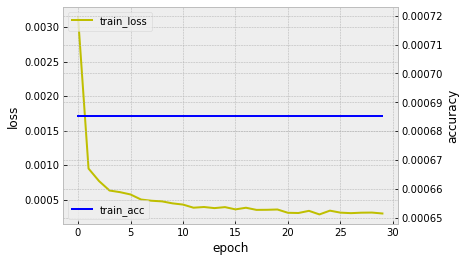

In [16]:
loss_ax = plt.subplot()
acc_ax = loss_ax.twinx()

loss_ax.plot(report.losses, 'y', label='train_loss')
acc_ax.plot(report.accs, 'b', label='train_acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()
#주식 특징집합의 train_acc가 0.005밖에 안된다

# Predict

In [17]:
#train, test prediction
train_pred = model.predict(xtrain,batch_size=n_batch) # x[0~window_size-1] 만큼의 특징벡터를 학습해서 학습데이터 수 
#model.reset_states()
test_pred = model.predict(xtest,batch_size=n_batch)
#model.reset_states()
real_test_pred = scaler.inverse_transform(test_pred)

In [18]:
tom_real = xtrain[-1]
tom_real = np.vstack((tom_real[1:], price[-1])) #test_pred[-1] 대신에 price[-1]
tom_real.shape

tom_pred = xtest[-1]
tom_pred = np.vstack((tom_pred[1:], test_pred[-1])) #마지막 데이터에 예측값
tom_pred.shape

(60, 1)

In [19]:
#학습된 모델로 예측하기
seq_in = tom_real #오늘꺼 예측자를 마지막 데이터로 추가해준 Input 샘플 or real 데이터 추가
#first_in = xtest[-1]  #test 샘플 마지막. 여기에다가 다음날 pred를 추가해줄거임
after_pred = np.zeros((predict_day,1))

for i in range(predict_day):
  sample_in = seq_in.reshape(1,window_size,1)
  after = model.predict(sample_in, batch_size=n_batch)
  model.reset_states()
  seq_in = np.vstack((seq_in[1:], after))
  after_pred[i] = after
  
#model.reset_states()
real_after_pred = scaler.inverse_transform(after_pred)

In [20]:
# #학습결과 그래프

# plt.figure(figsize=(20,10))
# plt.plot(price)
# #price = np.asarray(price)

# train_loss = 0.0
# test_loss = 0.0

# for i in range(train_test_split):
#   train_loss += price[i+window_size] - train_pred[i]  #5~1204까지
# for j in range(len(test_pred)-1):
#   test_loss += price[j+split_pt] - test_pred[j] # 1205 ~ 1915까지 
# train_loss /= train_test_split
# test_loss /= len(test_pred)

# #train_acc += metric(train_pred, y)
# #test_acc += metric(test_pred, y)

# plt.plot(np.arange(0, len(price),1), price, color='b')
# plt.plot(np.arange(window_size, split_pt, 1), train_pred, color='g')
# plt.plot(np.arange(split_pt, split_pt + len(test_pred), 1), test_pred, color='r')
# plt.plot(np.arange(len(price), len(price) + predict_day, 1), after_pred, color='y')

# print(
#     '현재 종가: ', price[-1], #x는 마지막값 누락
#     '예측 종가: ', test_pred[-1],
#     '훈련 loss: ', train_loss,
#     '테스트 loss: ', test_loss,
#     '마지막 오차: ',  price[-1] - test_pred[-1], sep='\n')

현재 종가: 
0.3964686998394863
예측 종가: 
[0.5705657]
오 차 율: 
[-0.43911916]


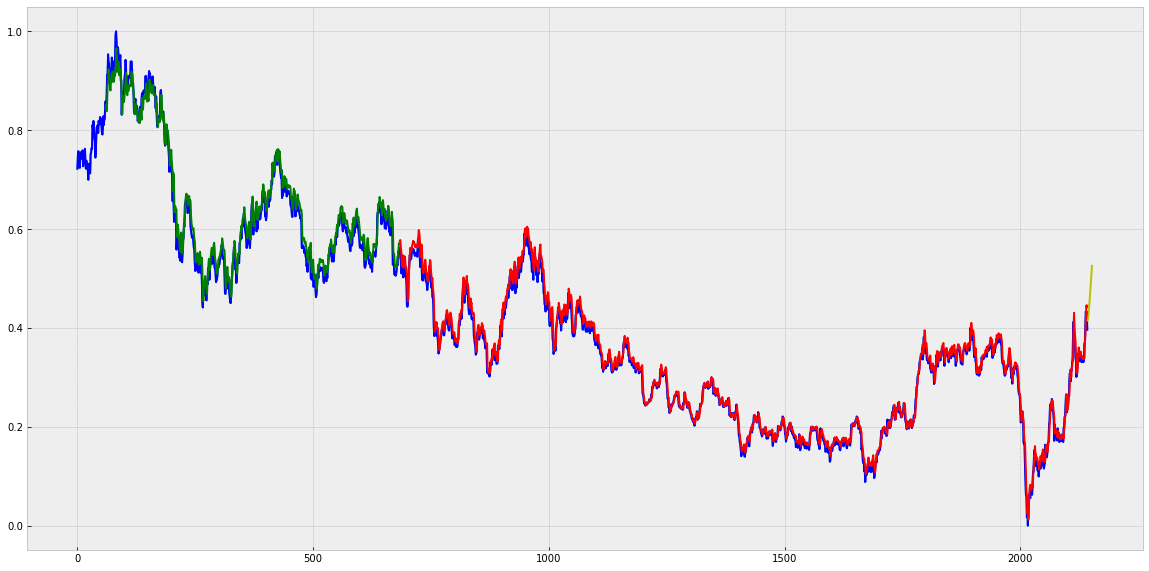

In [24]:
#학습결과 그래프
split_pt = train_test_split + window_size
plt.figure(figsize=(20,10))
plt.plot(price)

plt.plot(np.arange(0, len(price),1), price, color='b')
# plt.plot(np.arange(window_size, split_pt, 1), train_pred, color='g')
# plt.plot(np.arange(split_pt, split_pt + len(test_pred), 1), test_pred, color='r')
# plt.plot(np.arange(len(price), len(price) + len(after_pred), 1), after_pred, color='y')
plt.plot(np.arange(window_size, split_pt, 1), test_pred, color='g')
plt.plot(np.arange(split_pt, split_pt + len(train_pred), 1), train_pred, color='r')
plt.plot(np.arange(len(price), len(price) + len(after_pred), 1), after_pred, color='y')

print(
    '현재 종가: ', price[-1], #x는 마지막값 누락
    '예측 종가: ', test_pred[-1],
    '오 차 율: ',  (price[-1] - test_pred[-1]) / price[-1], sep='\n')

In [ ]:
# trace = go.Scatter(x=np.arange(0,len(price),1), y=price, #0~1915까지 해야함 재정규화로 matrix되면 reshape해주어 1차행렬로 만들어야함
# mode = 'lines', name='original')
# trace2 = go.Scatter(x=np.arange(window_size,split_pt,1), y=train_pred.reshape(train_test_split), #(5,1205,1) 이지만, 5~1204까지 적용 다 마찬가지
# mode = 'lines', name='train')
# trace3 = go.Scatter(x=np.arange(split_pt,split_pt + len(test_pred),1), y=test_pred.reshape(len(test_pred)),  #1205~1915
# mode = 'lines', name='pred')
# trace4 = go.Scatter(x=np.arange(len(price), len(price)+predict_day, 1), y =after_pred.reshape(len(after_pred)),
# mode = 'lines', name= 'after_pred')

# data = [trace, trace2, trace3, trace4]
# layout = go.Layout(title=Title)

# fig = go.Figure(data=data, layout=layout)
# #py.offline.plot(fig, show_link=True, filename=Title + '.html')
# py.offline.iplot(fig)

# from google.colab import files
# #files.download(filename=Title+'.html')

In [27]:
makeplot(Title)

In [ ]:
print('현재 종가: ', real_price[-1], #df, series는 -1 인덱싱 안됨
      '\n다음 예측가격: \n', real_after_pred)

In [ ]:
plt.plot(np.arange(0,len(after_pred), 1), after_pred, color='red')

#2020-07-16 128cell 60win 1bat 1500ep 0.2drop True(0.0068, 0.0147)
현재 종가:  54700.0 
다음 예측가격: 
 [
 [54893.63160133]
 [54766.0091877 ]
 [54602.36825943]
 [54522.68424034]
 [54475.19669533]
 [54446.21725082]
 [54428.90172005]
 [54419.37861443]
 [54414.94865417]
 [54415.34714699]]

 #'삼성전자: 2020-07-21 128cell 55win 1bat 2000ep 0.2drop True.h5' (0.00000, 0.00174) train:추종, test: 1998~2012(과잉) 제외 추종, after: 미세하락
학습률을 낮추니까 확실히 과잉이 줄어듬.
#주식데이터로는 완벽적합이 발생하지 않는다 왜???

#7/29일 유의미 after 발견
[2020-07-30] 128cell 25win 1bat 2000ep 0.2drop True 0.001lr
train_loss가 자연수로 튄 구간있지만, train,test 완전추종
값 오차율: 1.29%
방향정확도: 48.40%
MCC: 0.05

값 오차율: 1.42%
방향정확도: 44.76%
MCC: -0.04

값 오차율: 0.98%
방향정확도: 66.67%
MCC: 0.45


[2012-01-01 ~ 2020-07-31] 128cell 10win 1bat 2000ep 0.2drop True 0.001lr
train, test: 완전추종, after 무의미

[2014-01-01 ~ 2020-08-04] 128cell 10win 1bat 4000ep 0.2drop True 0.001lr
3h 40m밖에 안해서 과잉적합이 발생하지 않은건가? acc:0.0018로 증가
train, test: 완전추종, after: 무의미

[2014-01-01 ~ 2020-08-05] 128cell 10win 1bat 3000ep 0.3drop True 0.001lr
train, test: 완전추종
값 오차율: 1.24%
방향정확도: 55.31%
MCC: 0.10

값 오차율: 1.41%
방향정확도: 47.16%
MCC: -0.02

[2014-01-01 ~ 2020-08-07] 128cell 15win 1bat 6000ep 0.3drop True 0.001lr
과잉적합 학습실패 추종 아닌 구간도 없음

[2014-01-01 ~ 2020-08-17] 128cell 72win 1bat 1300ep 0.2drop True 0.001lr
btc로 1400ep한거는 완전추종되었는데 이건 왜이럴까?

[2012-01-01 ~ 2020-09-17] 128cell 84win 1bat 5500ep 0.2drop True 0.0001lr #12 h
train,test: 완전추종, after: 무의미


In [2]:
#작업후 GPU메모리 반납
from numba import cuda
cuda.select_device(0)
cuda.close()